In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Library.preprocess import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings(action='ignore') 
import missingno as msno


plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)
print(f"CPU count : {os.cpu_count()}")

/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPU count : 8


### 수비수 데이터셋 로드

In [3]:
with open('datas/defender.pkl', 'rb') as f:
    defender_df = pickle.load(f)

In [4]:
defender_df = preprocess_df(defender_df)
defender_df.tail()

,market_value,app,conceded_goals,clean_sheets,yellow_card,second_yell,red_card,age,height,position,foot,club,outfitter,cup,Tackles,Inter,Fouls,Offsides,Clear,Drbed,Blocks,OwnG,Rating,Goals,Assists,SpG,Fouled,Off,Disp,UnsTch,Drb,KeyP,AvgP,PS,Crosses,LongB,ThrB,AerialsWon,MotM,period,total_out
737,450000,15,0.000000,0.066667,0.133333,0.000000,0.000000,22,177,Centre-Back,right,0,others,0,0.9,1.6,0.4,0.4,3.3,0.3,0.4,0.0,6.52,0.000000,0.000000,0.4,0.9,0.0,0.1,0.2,0.1,0.1,38.0,88.4,0.0,1.9,0.0,1.1,0.0,3.1,0.000000
738,2700000,26,0.076923,0.115385,0.153846,0.000000,0.000000,26,173,Left-Back,left,0,others,4,1.9,1.4,0.6,0.1,2.1,0.7,0.3,0.0,6.80,0.076923,0.115385,0.5,1.5,0.0,0.4,1.2,0.6,0.7,38.5,79.8,0.3,2.2,0.0,0.8,2.0,4.1,0.000000
739,1800000,21,0.000000,0.000000,0.095238,0.047619,0.047619,24,179,Left-Back,left,0,others,0,0.7,2.1,0.8,0.2,3.0,0.4,0.6,0.0,6.39,0.000000,0.000000,0.4,1.5,0.0,0.2,0.3,0.1,0.0,42.1,80.2,0.0,3.1,0.0,1.5,0.0,2.1,0.095238
740,2250000,23,0.000000,0.000000,0.000000,0.000000,0.000000,25,170,Right-Back,right,0,others,0,1.1,1.1,0.7,0.2,1.6,0.6,0.1,0.0,6.29,0.000000,0.000000,0.3,0.5,0.0,0.1,0.7,0.5,0.5,22.9,75.8,0.2,0.7,0.0,0.6,0.0,5.1,0.000000
741,1800000,22,0.000000,0.090909,0.181818,0.000000,0.000000,22,175,Right-Back,right,0,others,0,2.4,1.0,1.1,0.1,1.4,0.7,0.1,0.0,6.48,0.000000,0.090909,0.2,1.2,0.0,0.8,1.2,0.8,0.2,32.5,78.0,0.1,1.7,0.0,0.3,0.0,2.8,0.000000


#### categorical variances 더미변수화

In [38]:
model_df = pd.get_dummies(defender_df, columns=['position', 'foot', 'outfitter'])

### 초기 모델
- 범주형 : 더미변수화
- 수치형 : 전처리만 진행
- 종속변수 : original

In [39]:
dfX0 = model_df.loc[:, 'app':]
dfy = model_df['market_value']

train_X, test_X, train_y, test_y = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(519, 46) (519,) (223, 46) (223,)


MSE :  63877744500167.5
RMSE :  7992355.378745836
r2-score :  0.38993763594794306


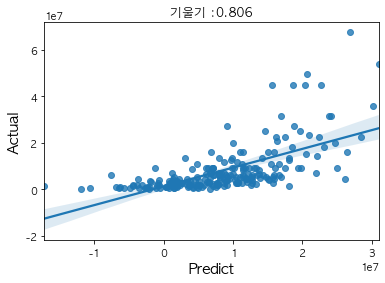

In [40]:
model_lm = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_lm = model_lm.predict(test_X)

print("MSE : ", mean_squared_error(test_y, pred_lm))
print("RMSE : ", np.sqrt(mean_squared_error(test_y, pred_lm)))
print("r2-score : ",r2_score(test_y, pred_lm))
f = np.polyfit(pred_lm, test_y, deg=1)

sns.regplot(x=pred_lm, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### Standard, MinMax, Robust 모델 비교
- 범주형 : 더미변수화
- 수치형 : 각 스케일러 적용
- 종속변수 : original

In [41]:
ss = StandardScaler().fit(dfX0.loc[:, "app":"total_out"].values)
mm = MinMaxScaler().fit(dfX0.loc[:, "app":"total_out"].values)
rb = RobustScaler().fit(dfX0.loc[:, "app":"total_out"].values)

ss_values = ss.transform(dfX0.loc[:, "app":"total_out"].values)
mm_values = mm.transform(dfX0.loc[:, "app":"total_out"].values)
rb_values = rb.transform(dfX0.loc[:, "app":"total_out"].values)

ss_dfX0 = np.hstack([ss_values , dfX0.loc[:, "position_Centre-Back":].values])
mm_dfX0 = np.hstack([mm_values , dfX0.loc[:, "position_Centre-Back":].values])
rb_dfX0 = np.hstack([rb_values , dfX0.loc[:, "position_Centre-Back":].values])

In [42]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

ss_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_ss = ss_model.predict(test_X)

print("S-scaled MSE : ", mean_squared_error(test_y, pred_ss))
print("S-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_ss)))
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))

S-scaled MSE :  63879559526790.02
S-scaled RMSE :  7992468.925606782
S-scaled r2-score :  0.3899203015940015


In [43]:
train_X, test_X, train_y, test_y = train_test_split(mm_dfX0, dfy, test_size=0.3, random_state=3)

mm_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_mm = mm_model.predict(test_X)

print("M-scaled MSE : ",mean_squared_error(test_y, pred_mm))
print("M-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_mm)))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))

M-scaled MSE :  63809220081870.35
M-scaled RMSE :  7988067.3558671465
M-scaled r2-score :  0.3905920762220755


In [44]:
train_X, test_X, train_y, test_y = train_test_split(rb_dfX0, dfy, test_size=0.3, random_state=3)

rb_model = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_rb = rb_model.predict(test_X)

print("R-scaled MSE : ",mean_squared_error(test_y, pred_rb))
print("R-scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rb)))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

R-scaled MSE :  63877744500167.586
R-scaled RMSE :  7992355.378745842
R-scaled r2-score :  0.3899376359479422


In [45]:
f1 = np.polyfit(pred_ss, test_y, deg=1)
f2 = np.polyfit(pred_mm, test_y, deg=1)
f3 = np.polyfit(pred_rb, test_y, deg=1)

S-scaled r2-score :  0.3899203015940015
M-scaled r2-score :  0.3905920762220755
R-scaled r2-score :  0.3899376359479422


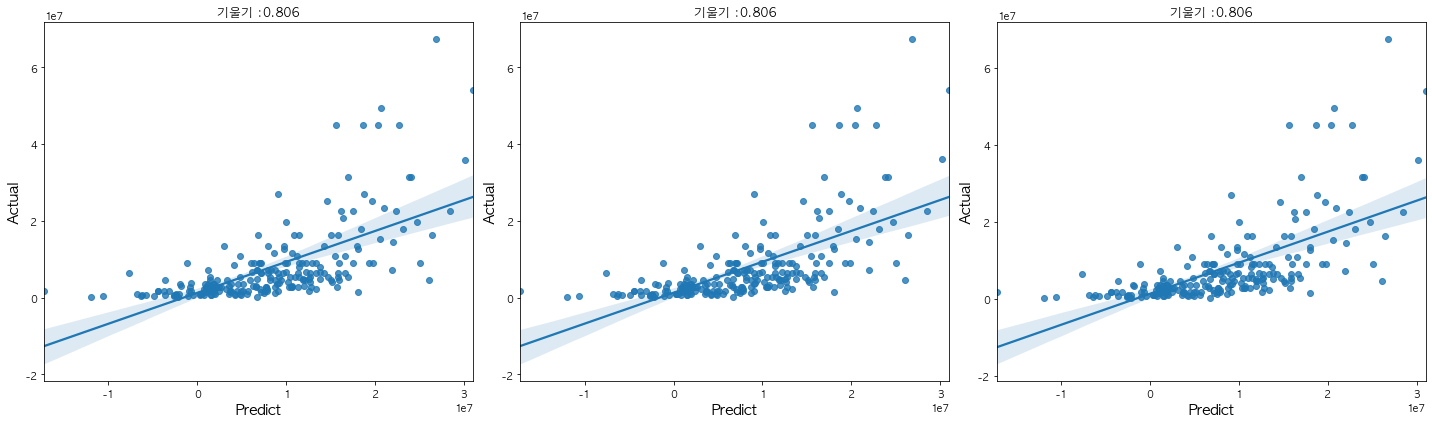

In [46]:
print("S-scaled r2-score : ",r2_score(test_y, pred_ss))
print("M-scaled r2-score : ",r2_score(test_y, pred_mm))
print("R-scaled r2-score : ",r2_score(test_y, pred_rb))

plt.figure(figsize=(20, 6))

plt.subplot(131)
sns.regplot(x=pred_ss, y=test_y)
plt.title(f"기울기 :{f1[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(132)
sns.regplot(x=pred_mm, y=test_y)
plt.title(f"기울기 :{f2[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(133)
sns.regplot(x=pred_rb, y=test_y)
plt.title(f"기울기 :{f3[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.tight_layout()
plt.show()

### 종속변수에 log scaling을 진행한 모델
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [47]:
log_dfy = np.log1p(model_df['market_value'])

train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

log_scaled MSE :  0.5857652916474115
log_scaled RMSE :  0.7653530503286777
Inverse log한 RMSE :  7394704.284064515
log_scaled r2-score :  0.5514005769482347


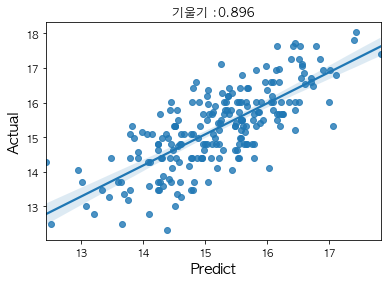

In [48]:
model_log = LinearRegression(fit_intercept=True).fit(train_X, train_y)
pred_log = model_log.predict(test_X)
f = np.polyfit(pred_log, test_y, deg=1)

print("log_scaled MSE : ", mean_squared_error(test_y, pred_log))
print("log_scaled RMSE : ",np.sqrt(mean_squared_error(test_y, pred_log)))
print("Inverse log한 RMSE : ", np.sqrt(np.sum((((np.exp(test_y) -1) - (np.exp(pred_log) -1))**2)) / len(test_y)))
print("log_scaled r2-score : ",r2_score(test_y, pred_log))

sns.regplot(x=pred_log, y=test_y)
plt.title(f"기울기 :{f[0].round(3)}")
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

### RandomForest Regessor Model 적용
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : original and log1p Scaler

In [49]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, dfy, test_size=0.3, random_state=3)

rf_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf = rf_model.predict(test_X)

print("RF MSE : ", mean_squared_error(test_y, pred_rf))
print("RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf)))
print("RF r2-score : ",r2_score(test_y, pred_rf))

RF MSE :  54053407398618.836
RF RMSE :  7352102.243482393
RF r2-score :  0.48376465448644823


In [50]:
train_X, test_X, train_y, test_y = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

rf_log_model = RandomForestRegressor().fit(train_X, train_y)
pred_rf_log = rf_log_model.predict(test_X)

print("log_RF MSE : ", mean_squared_error(test_y, pred_rf_log))
print("log_RF RMSE : ",np.sqrt(mean_squared_error(test_y, pred_rf_log)))
print("log_RF r2-score : ",r2_score(test_y, pred_rf_log))

log_RF MSE :  0.5210997897557453
log_RF RMSE :  0.7218724193067257
log_RF r2-score :  0.6009236662360438


### GridSearchCV를 통한 best hyper parameter 추출
- model : RandomForest Regessor
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [ ]:
random_params = {'bootstrap': [True, False],
 'max_depth': [1,3,5,7,9],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

result = GridSearchCV(
    RandomForestRegressor(),
    param_grid=random_params,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=3)

result.fit(train_X, train_y)

In [29]:
result.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 800}

In [51]:
params = {
    'bootstrap': True,
    'max_depth': 9,
    'max_features': 'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 800
}

In [52]:
grid_model = RandomForestRegressor(**params).fit(train_X, train_y)
pred_grid = grid_model.predict(test_X)

print(mean_squared_error(test_y, pred_grid))
print(np.sqrt(mean_squared_error(test_y, pred_grid)))
print(r2_score(test_y, pred_grid))

0.5095547208131751
0.7138310169873365
0.6097652813685555


### Pipeline을 이용한 Model 생성
- ploynomialFeatures을 이용한 다향회귀 진행 : 삼차항
- pipeline : `PolynomialFeatures > StandardScaler > RandomForestRegressor`
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [32]:
pipe = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_params = {
#     'ploy__degree': [3],
#     'rf__bootstrap': [True],
#     'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [2, 4, 8],
    'rf__min_samples_split': [2, 4, 8],
    'rf__n_estimators': [200, 1000]
}

pipe_grid = HalvingGridSearchCV(pipe, param_grid=pipe_params, verbose=2, n_jobs=os.cpu_count()-2,
                                scoring="roc_auc", min_resources="exhaust", cv=3)
pipe_grid.fit(train_X, train_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 57
max_resources_: 519
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 57
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 6
n_resources: 171
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 513
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/riversong/miniforge3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('ploy',
                                               PolynomialFeatures(degree=3)),
                                              ('scaler', StandardScaler()),
                                              ('rf', RandomForestRegressor())]),
                    n_jobs=6,
                    param_grid={'rf__min_samples_leaf': [2, 4, 8],
                                'rf__min_samples_split': [2, 4, 8],
                                'rf__n_estimators': [200, 1000]},
                    refit=<function _refit_callable at 0x16367cdc0>,
                    scoring='roc_auc', verbose=2)

In [33]:
ploy3_params = pipe_grid.best_params_
ploy3_params

{'rf__min_samples_leaf': 8,
 'rf__min_samples_split': 8,
 'rf__n_estimators': 200}

In [53]:
pipe_2 = Pipeline([
    ('ploy', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(min_samples_leaf=8,
                                min_impurity_split=8,
                                n_estimators=200))
])

result_2 = pipe_2.fit(train_X, train_y)
pred_2 = result_2.predict(test_X)

print(mean_squared_error(test_y, pred_2))
print(np.sqrt(mean_squared_error(test_y, pred_2)))
print(r2_score(test_y, pred_2))

1.3058549407766586
1.1427401020252412
-6.910852328045891e-05


### 최종 모델 선정 및 OLS객체를 통한 통계분석
- model : LinearRegression
- 범주형 : 더미변수화
- 수치형 : Standard Scaler
- 종속변수 : log1p Scaler

In [54]:
train_X, test_X, train_y, test_y1 = train_test_split(dfX0, dfy, test_size=0.3, random_state=3)
train_X, test_X, train_y, test_y2 = train_test_split(ss_dfX0, log_dfy, test_size=0.3, random_state=3)

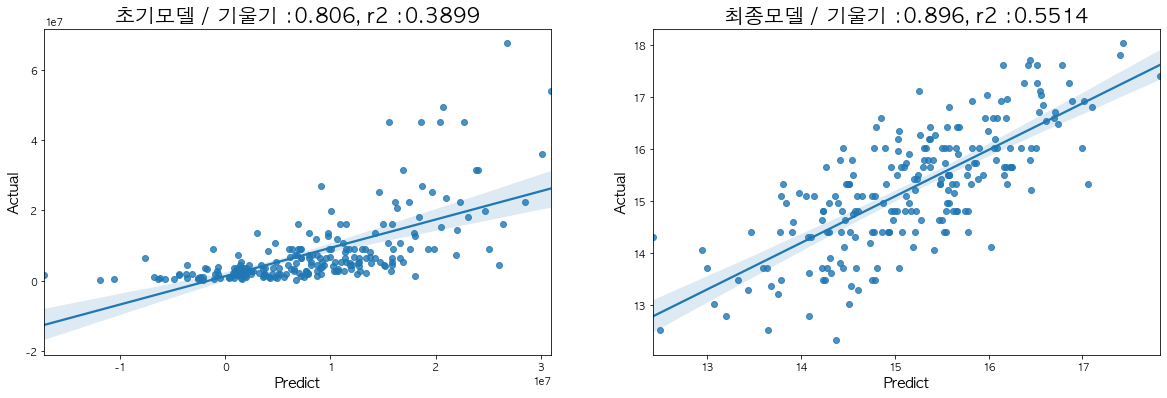

In [55]:
f1 = np.polyfit(pred_lm, test_y1, deg=1)
f2 = np.polyfit(pred_log, test_y2, deg=1)

plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.regplot(x=pred_lm, y=test_y1)
plt.title(f"초기모델 / 기울기 :{f1[0].round(3)}, r2 :{np.round(r2_score(test_y1, pred_lm), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.subplot(122)
sns.regplot(x=pred_log, y=test_y2)
plt.title(f"최종모델 / 기울기 :{f2[0].round(3)}, r2 :{np.round(r2_score(test_y2, pred_log), 4)}", fontsize=20)
plt.xlabel('Predict', fontsize=15)
plt.ylabel("Actual", fontsize=15)

plt.show()

In [56]:
X0 = pd.DataFrame(StandardScaler().fit_transform(dfX0), columns=dfX0.columns)
X1 = sm.add_constant(X0)
y = log_dfy

final_model = sm.OLS(y, X1).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     31.71
Date:                Tue, 15 Jun 2021   Prob (F-statistic):          1.57e-133
Time:                        18:02:53   Log-Likelihood:                -795.74
No. Observations:                 742   AIC:                             1677.
Df Residuals:                     699   BIC:                             1876.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.2644 

In [27]:
# p-value <= 0.1인 index 추출
idx = final_model.pvalues[1:] <= 0.1

final_model.params[1:][idx]

app                 0.261176
conceded_goals      0.308406
age                -0.428666
club                0.304761
cup                 0.156563
Tackles            -0.106728
Inter              -0.121279
Offsides            0.107466
Blocks              0.099654
Rating              0.256655
Goals              -0.315267
Off                 0.056377
UnsTch              0.102745
AvgP                0.231093
ThrB                0.052689
period              0.141782
foot_both          -0.051450
outfitter_Nike      0.068809
outfitter_adidas   -0.049062
dtype: float64

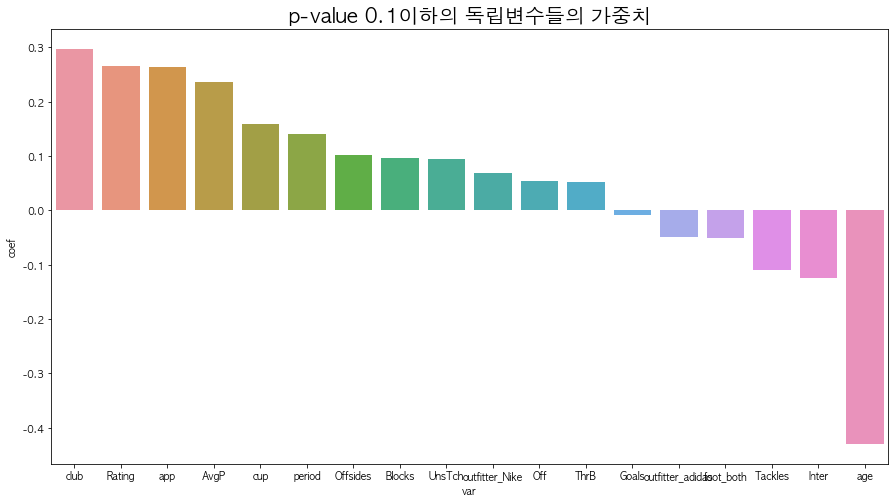

In [57]:
result_df = final_model.params[1:][idx].reset_index().rename(columns={"index": "var", 0: "coef"})
result_df.sort_values('coef', ascending=False, inplace=True)

plt.figure(figsize=(15, 8))

sns.barplot(data=result_df, x='var', y='coef')
plt.title("p-value 0.1이하의 독립변수들의 가중치", fontsize=20)

plt.show()